# Exploration

In this section, I attempt to explore the data in depth and also answer some of the questions I developed in the Wrangle section.

1. Across duration and size of packets, where do the attack patterns tend to lie? Types of services? Protocols?
2. Which services are attack patterns usually targeting?
3. Which protocols are attack patterns usually targeting?
4. What is the distribution of attacks to normal traffic? How does this compare with the services and protocols being used? How does this compare with the duration and size of packets?

## Import the data
I need to start first with importing the data.

In [1]:
# For pulling the data
import wrangle as w

# For working with the data
import pandas as pd
import numpy as np

# For visualizing the data
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train,validate,test = w.wrangle_iot2022()

Reading from file...


In [5]:
train.shape

(86181, 84)

## Question 1:
### Across duration and size of packets, where do the attack patterns tend to lie? 


In [156]:
train.columns

Index(['id.orig_p', 'id.resp_p', 'proto', 'service', 'flow_duration',
       'fwd_pkts_tot', 'bwd_pkts_tot', 'fwd_data_pkts_tot',
       'bwd_data_pkts_tot', 'fwd_pkts_per_sec', 'bwd_pkts_per_sec',
       'flow_pkts_per_sec', 'down_up_ratio', 'fwd_header_size_tot',
       'fwd_header_size_min', 'fwd_header_size_max', 'bwd_header_size_tot',
       'bwd_header_size_min', 'bwd_header_size_max', 'flow_FIN_flag_count',
       'flow_SYN_flag_count', 'flow_RST_flag_count', 'fwd_PSH_flag_count',
       'bwd_PSH_flag_count', 'flow_ACK_flag_count', 'fwd_URG_flag_count',
       'flow_CWR_flag_count', 'flow_ECE_flag_count', 'fwd_pkts_payload.min',
       'fwd_pkts_payload.max', 'fwd_pkts_payload.tot', 'fwd_pkts_payload.avg',
       'fwd_pkts_payload.std', 'bwd_pkts_payload.min', 'bwd_pkts_payload.max',
       'bwd_pkts_payload.tot', 'bwd_pkts_payload.avg', 'bwd_pkts_payload.std',
       'flow_pkts_payload.min', 'flow_pkts_payload.max',
       'flow_pkts_payload.tot', 'flow_pkts_payload.avg',
     

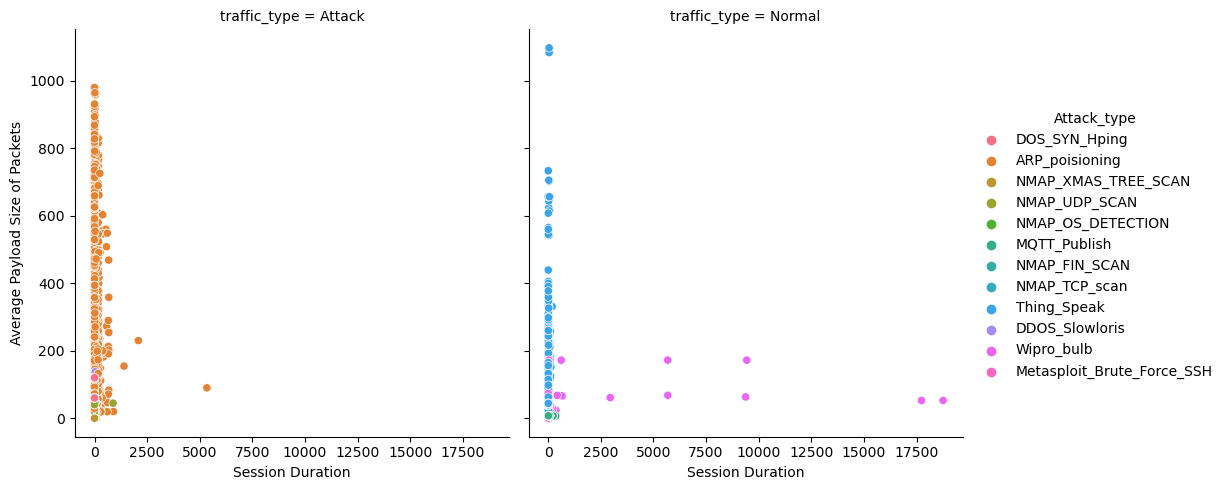

In [164]:
sns.relplot(
    data=train,
    x='flow_duration',
    y='flow_pkts_payload.avg',
    hue='Attack_type',
    kind='scatter',
    col='traffic_type'
).set_axis_labels("Session Duration", "Average Payload Size of Packets")

plt.show()

### Where do the types of services tend to lie?

### Where do the protocols tend to lie?

In order to accomplish this, I want to create a scatterplot of the packet durations and sizes.

For this, I'm looking at flow_duration and flow_pkts_payload.tot.

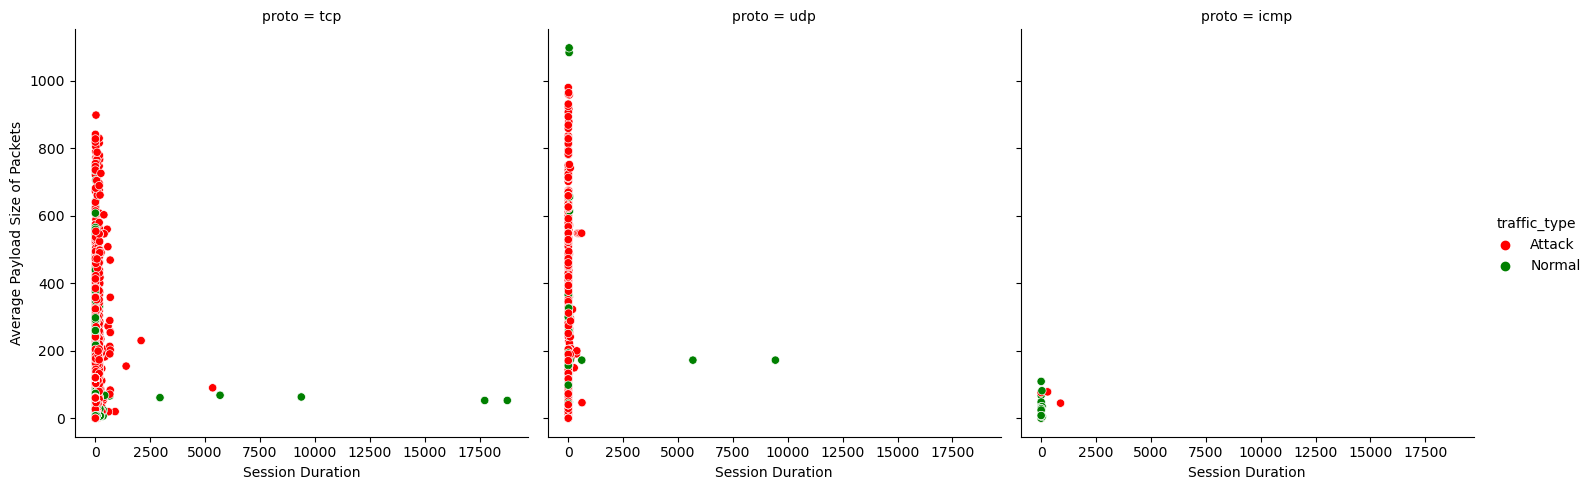

In [124]:
sns.relplot(
    data=train,
    x='flow_duration',
    y='flow_pkts_payload.avg',
    hue='traffic_type',
    palette={"Attack": "red", "Normal": "green"},
    kind='scatter',
    col='proto'
).set_axis_labels("Session Duration", "Average Payload Size of Packets")

plt.show()

The attack patterns tend to be very similar to normal traffic, which is to be expected since an attacker would desire to go unnoticed.

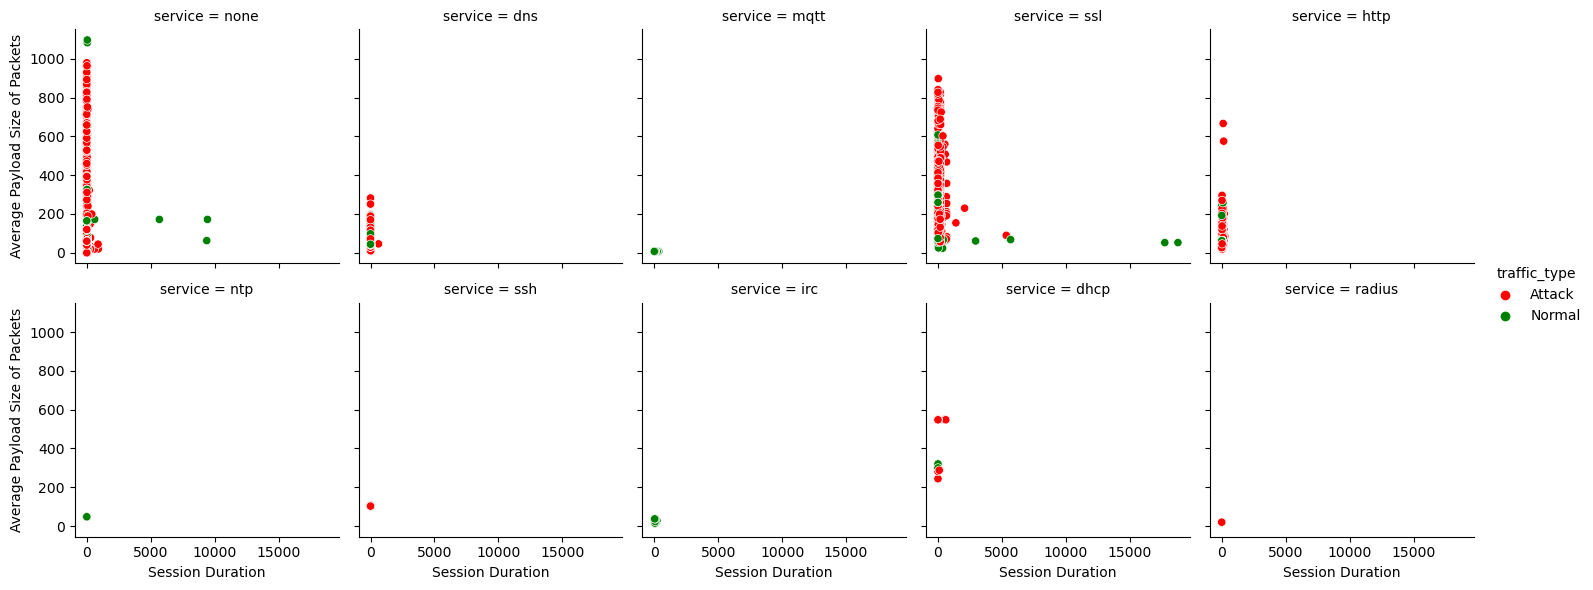

In [97]:
sns.relplot(
    data=train,
    x='flow_duration',
    y='flow_pkts_payload.avg',
    hue='traffic_type',
    palette={"Attack": "red", "Normal": "green"},
    kind='scatter',
    col='service',
    col_wrap=5,
    height=3,
    aspect=1  # Adjust aspect ratio to spread plots wider
).set_axis_labels("Session Duration", "Average Payload Size of Packets")

plt.show()

Here we can see that there are some services that don't appear to be targeted, such as irc, ntp, and mqtt.

I'd like to verify that, though.

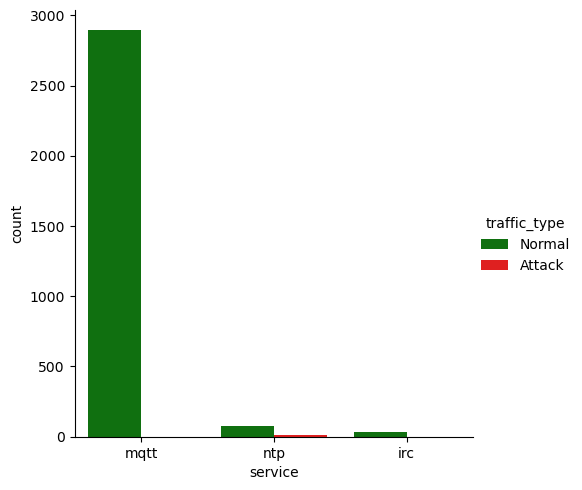

service  traffic_type
mqtt     Normal          2893
ntp      Normal            74
irc      Normal            31
ntp      Attack            10
Name: count, dtype: int64

In [122]:
sns.catplot(
    kind='count',
    data=train[train['service'].isin(['irc', 'mqtt', 'ntp'])],
    x='service',
    hue='traffic_type',
    palette={"Attack": "red", "Normal": "green"}
)

plt.show()

# Show the raw data
train[train['service'].isin(['irc', 'mqtt', 'ntp'])][['service','traffic_type']].value_counts()

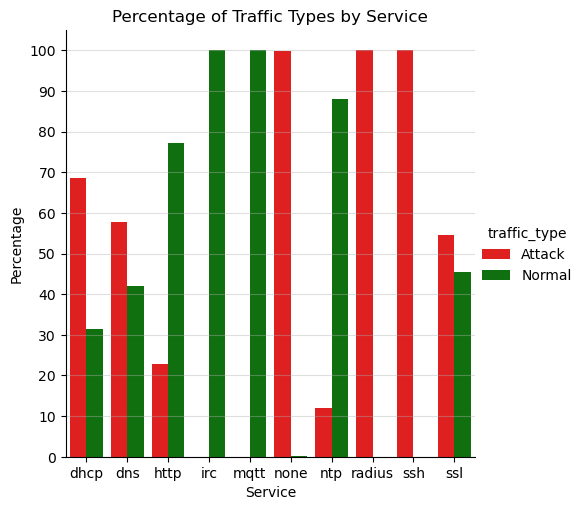

In [140]:
# Step 1: Calculate counts
grouped = train.groupby(['service', 'traffic_type']).size().reset_index(name='counts')

# Step 2: Calculate total counts for each service to use for percentage calculation
total_counts = grouped.groupby('service')['counts'].transform('sum')

# Convert counts to percentages
grouped['percentage'] = (grouped['counts'] / total_counts) * 100

# Step 3: Create the plot
sns.catplot(
    kind='bar',  # Use bar type to show percentages
    data=grouped,
    x='service',
    y='percentage',
    hue='traffic_type',
    palette={"Attack": "red", "Normal": "green"}
)

# Adding more descriptive labels
plt.xlabel('Service')
plt.ylabel('Percentage')
plt.yticks(list(range(0,110,10)))
plt.title('Percentage of Traffic Types by Service')
plt.grid(alpha=0.4,axis='y')

plt.show()

## Question 2:
### Which services are attack patterns usually targeting?

## Question 3:
### Which protocols are attack patterns usually targeting?

## Question 4:
### What is the distribution of attacks to normal traffic? 


### How does this compare with the services and protocols being used? 

### How does this compare with the duration and size of packets?